<h3>Regular expressions (aka regexps)</h3>

Konrad Przewłoka

<h4>Necessary imports:</h4>

In [177]:
import re
import os
import functools
!pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip


<h4>Load data:</h4>

In [178]:
data=[]
data_dict={}
for file in os.listdir('../ustawy'):
    with open("../ustawy/"+file, "r", encoding="utf8") as f:
        text = functools.reduce(lambda a,b: a + b, f.readlines())
        year = int(file[0:4])
        data.append([year,text])
        
for [year,text] in data:
    if year not in data_dict.keys():
        data_dict[year]=[text]
    else:
        data_dict[year].append(text)

    
data_dict.keys()

dict_keys([1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004])

<h4>Utility functions</h4>

In [179]:
#count pattern matches by year
def count_per_year(pattern,data):
    result={}
    for key in data.keys():
        count=0
        for text in data[key]:
            count+=len(re.findall(pattern,text.lower()))
        result[key]=count
    return result

def count_all(pattern,data):
    result=0
    for key in data.keys():
        for text in data[key]:
            result+=len(re.findall(pattern,text))
    return result

<h4>Basic data analysis:</h4>
according to 'zasady techniki prawodawczej' we can distinguish following types of units in bills:
<ul>
<li> artykuł</li>
<li> paragraf</li>
<li> ustęp</li>
<li> punkt</li>
<li> litera</li>
 </ul>
Knowing this we can prepare a regex as such:
<p>(art\.|§|ust\.|pkt|lit\.)\s+\d+[a-z]?</p>


<h4>Counting bill amendments</h4>
A manual review of a sample of data was conducted and a following construction matching given criteria and not given as an example in the task was found:
<ul>
    <li>pkt 3 i 4 otrzymują brzmienie</li>
</ul>

This construction has been classified as a change of unit. 
Other examples have not been found during the text reviews.

In [180]:
#Addition of unit
add_regex='dodaje\s+się\s+(art\.|§|ust\.|pkt|lit\.)\s+\d+[a-z]?'
add_result = count_per_year(add_regex,data_dict)


#Removal of unit
rm_regex='(art\.|§|ust\.|pkt|lit\.)\s+\d+[a-z]?\s+skreśla\s+się\s+'
rm_result = count_per_year(rm_regex,data_dict)


#Change of unit
change1_regex='(art\.|§|ust\.|pkt|lit\.)\s+\d+[a-z]?\s+otrzymuje\s+brzmienie'
change1_result = count_per_year(change1_regex,data_dict)

change2_regex='(art\.|§|ust\.|pkt|lit\.)\s+\d+[a-z]?\s+i\s+\d+\s+otrzymują\s+brzmienie'
change2_result = count_per_year(change3_regex,data_dict)


change_result={}
sum_result={}
for year in data_dict.keys():
    change_result[year] = change1_result[year]+change2_result[year]
    sum_result[year] = change_result[year]+add_result[year]+rm_result[year]
    
print('Additions:')
print(add_result)
print('Removals:')
print(rm_result)
print('Changes:')
print(change_result)
add_percentage=[list(add_result.values())[i]*100/list(sum_result.values())[i] for i in range(12)]
rm_percentage=[list(rm_result.values())[i]*100/list(sum_result.values())[i] for i in range(12)]
change_percentage=[list(change_result.values())[i]*100/list(sum_result.values())[i] for i in range(12)]
histogram_tmp_bottom=[sum(x) for x in zip(rm_percentage, add_percentage)]

Additions:
{1993: 32, 1994: 105, 1995: 326, 1996: 498, 1997: 665, 1998: 217, 1999: 153, 2000: 759, 2001: 1096, 2002: 91, 2003: 1025, 2004: 1029}
Removals:
{1993: 14, 1994: 21, 1995: 74, 1996: 179, 1997: 210, 1998: 82, 1999: 39, 2000: 283, 2001: 186, 2002: 3, 2003: 51, 2004: 17}
Changes:
{1993: 61, 1994: 170, 1995: 361, 1996: 866, 1997: 1050, 1998: 288, 1999: 163, 2000: 1460, 2001: 1361, 2002: 183, 2003: 1807, 2004: 1591}


<h4>Chart of percentage distribution of amendment types per years</h4>

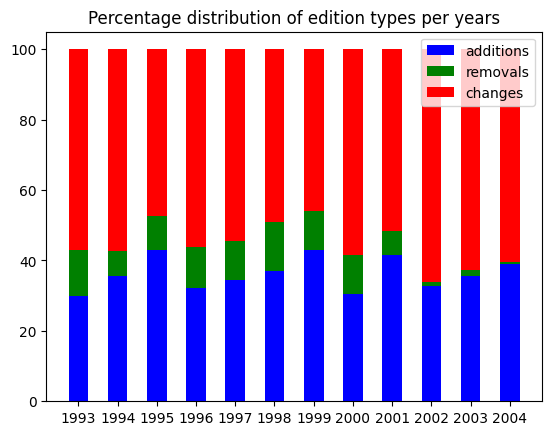

In [181]:
X = np.arange(12)
plt.title("Percentage distribution of edition types per years")
plt.bar(X , add_percentage, color = 'b',  label='additions', width=0.5)
plt.bar(X , rm_percentage, color = 'g', bottom=add_percentage, label='removals', width=0.5)
plt.bar(X , change_percentage, color = 'r', bottom=histogram_tmp_bottom , label='changes', width=0.5)
plt.xticks([r  for r in range(12)], [year for year in range(1993, 2005)])
plt.legend(loc='best')
plt.show()

<h4>Counting of "ustawa" occurences</h4>
We notice that all possible versions of the given word are constructed using base "ustaw" and adding postfixes such as "a" "ie" etc.
Knowing this we can construct a regex looking for all inflections known to us, such as this one:
<p>\b(ustaw(a|ie|y|ę|ą|e|om|ach|ami))\b</p>
then in order to make it case insensitive:
<p> \b((u|U)(s|S)(t|T)(a|A)(w|W)((a|A)|(i|I)(e|E)|(y|Y)|(ę|Ę)|(ą|Ą)|(e|E)|(o|O)(m|M)|(a|A)(c|C)(h|H)|(a|A)(m|M)(i|I)))\b</p>
<p>(\\b((u|U)(s|S)(t|T)(a|A)(w|W)((a|A)|(i|I)(e|E)|(y|Y)|(ę|Ę)|(ą|Ą)|(e|E)|(o|O)(m|M)|(a|A)(c|C)(h|H)|(a|A)(m|M)(i|I)))\\b)(?=\s+z dnia\\b)
</p>
<p>(\\b((u|U)(s|S)(t|T)(a|A)(w|W)((a|A)|(i|I)(e|E)|(y|Y)|(ę|Ę)|(ą|Ą)|(e|E)|(o|O)(m|M)|(a|A)(c|C)(h|H)|(a|A)(m|M)(i|I)))\\b)(?!\s+z dnia\\b)
</p>

In [182]:
#\\b((u|U)(s|S)(t|T)(a|A)(w|W)((a|A)|(i|I)(e|E)|(y|Y)|(ę|Ę)|(ą|Ą)|(e|E)|(o|O)(m|M)|(a|A)(c|C)(h|H)|(a|A)(m|M)(i|I)))\\b
ustawa_regex='\\b((u|U)(s|S)(t|T)(a|A)(w|W)((a|A)|(i|I)(e|E)|(y|Y)|(ę|Ę)|(ą|Ą)|(e|E)|(o|O)(m|M)|(a|A)(c|C)(h|H)|(a|A)(m|M)(i|I)))\\b'
count = count_all(ustawa_regex,data_dict)
count

24025

In [183]:
#(\\b((u|U)(s|S)(t|T)(a|A)(w|W)((a|A)|(i|I)(e|E)|(y|Y)|(ę|Ę)|(ą|Ą)|(e|E)|(o|O)(m|M)|(a|A)(c|C)(h|H)|(a|A)(m|M)(i|I)))\\b)(?=\s+z dnia\\b)
ustawa_regex_followed='(\\b((u|U)(s|S)(t|T)(a|A)(w|W)((a|A)|(i|I)(e|E)|(y|Y)|(ę|Ę)|(ą|Ą)|(e|E)|(o|O)(m|M)|(a|A)(c|C)(h|H)|(a|A)(m|M)(i|I)))\\b)(?=\s+z dnia\\b)'
count_followed = count_all(ustawa_regex_followed,data_dict)
count_followed

8101

In [184]:
#(\\b((u|U)(s|S)(t|T)(a|A)(w|W)((a|A)|(i|I)(e|E)|(y|Y)|(ę|Ę)|(ą|Ą)|(e|E)|(o|O)(m|M)|(a|A)(c|C)(h|H)|(a|A)(m|M)(i|I)))\\b)(?!\s+z dnia\\b)
ustawa_regex_not_followed='(\\b((u|U)(s|S)(t|T)(a|A)(w|W)((a|A)|(i|I)(e|E)|(y|Y)|(ę|Ę)|(ą|Ą)|(e|E)|(o|O)(m|M)|(a|A)(c|C)(h|H)|(a|A)(m|M)(i|I)))\\b)(?!\s+z dnia\\b)'
count_not_followed = count_all(ustawa_regex_not_followed,data_dict)
count_not_followed

15924

In [185]:
count_followed+count_not_followed

24025

<p>Number of occurences found in total: 24025</p>
<p>Number of occurences followed by 'z dnia': 8101</p>
<p>Number of occurences not followed by 'z dnia': 15924</p>
<p>Total number of occurences adds up</p>

In [186]:
ustawa_regex_change='(?<!o zmianie )(\\b((u|U)(s|S)(t|T)(a|A)(w|W)((a|A)|(i|I)(e|E)|(y|Y)|(ę|Ę)|(ą|Ą)|(e|E)|(o|O)(m|M)|(a|A)(c|C)(h|H)|(a|A)(m|M)(i|I)))\\b)'
count_change = count_all(ustawa_regex_change,data_dict)
count_change

23275

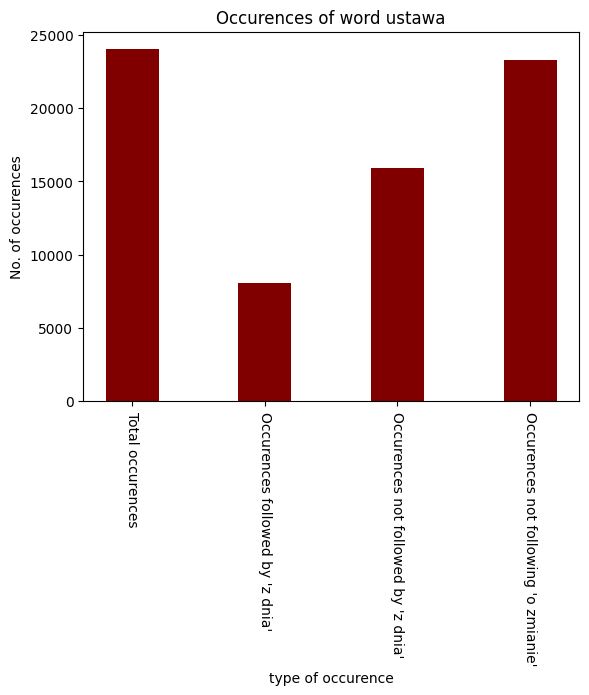

In [187]:
plt.bar(['Total occurences','Occurences followed by \'z dnia\'','Occurences not followed by \'z dnia\'','Occurences not following \'o zmianie\''], [count,count_followed,count_not_followed,count_change], color ='maroon',
        width = 0.4)
plt.xticks(rotation = -90)
plt.xlabel("type of occurence")
plt.ylabel("No. of occurences")
plt.title("Occurences of word ustawa")
plt.show()